In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as pg
from questdb.ingress import Sender
from datetime import datetime
from enum import Enum
%matplotlib inline

In [4]:
class SensorName(Enum):

    ACC = 'accelerometeruncalibrated'
    GYRO = 'gyroscopeuncalibrated'

In [5]:
def write_acc(data:dict, db_host:str, db_port:int, table_name:str):

    """
    Write phone accelerometer data to QuestDb 

    Parameters
    ----------
    data : dict
        The raw request data sent by the phone
    db_host : str
        The QuestDb host
    db_port: int
        The QuestDb port
    table_name : str
        The table to write to
    """

    session_id = data['sessionId']
    device_id = data['deviceId']

    for d in data['payload']:

        if d.get("name") == SensorName.ACC.value:

            ts = datetime.fromtimestamp(d["time"] / 1000000000)
            x = d["values"]["x"]
            y = d["values"]["y"]
            z = d["values"]["z"]
            

            with Sender(db_host, db_port) as sender:

                sender.row(
                    table_name,
                    symbols={'device_id':str(device_id),'session_id': str(session_id)},
                    columns={'recorded_timestamp': str(ts) , 'x':x, 'y':y, 'z':z})
                sender.flush()



In [12]:
connection = pg.connect(user="admin",
                            password="quest",
                            host="127.0.0.1",
                            port="8812",
                            database="qdb",
                            options='-c statement_timeout=300000')

In [13]:
data = pd.read_sql("select * from acc", connection)
data.sort_values('recorded_timestamp')

,device_id,session_id,recorded_timestamp,x,y,z,timestamp
0,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,57b53a65-3083-4f82-a2ba-416d3ee6bd40,2022-10-14 09:41:44.025523,-0.096954,-0.705643,-0.701004,2022-10-14 14:41:44.298334
1,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,57b53a65-3083-4f82-a2ba-416d3ee6bd40,2022-10-14 09:41:44.045576,-0.108795,-0.703171,-0.707672,2022-10-14 14:41:44.319671
2,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,57b53a65-3083-4f82-a2ba-416d3ee6bd40,2022-10-14 09:41:44.065629,-0.112823,-0.697952,-0.690796,2022-10-14 14:41:44.319689
3,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,57b53a65-3083-4f82-a2ba-416d3ee6bd40,2022-10-14 09:41:44.085682,-0.113068,-0.698395,-0.685043,2022-10-14 14:41:44.319698
4,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,57b53a65-3083-4f82-a2ba-416d3ee6bd40,2022-10-14 09:41:44.105735,-0.125366,-0.697052,-0.678741,2022-10-14 14:41:44.319708
...,...,...,...,...,...,...,...
509,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,57b53a65-3083-4f82-a2ba-416d3ee6bd40,2022-10-14 09:41:54.252513,0.152023,-0.266098,-0.958389,2022-10-14 14:41:54.379065
514,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,57b53a65-3083-4f82-a2ba-416d3ee6bd40,2022-10-14 09:41:54.272566,0.158630,-0.270309,-0.948944,2022-10-14 14:41:54.379189
512,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,57b53a65-3083-4f82-a2ba-416d3ee6bd40,2022-10-14 09:41:54.292619,0.168503,-0.273880,-0.953812,2022-10-14 14:41:54.379135
513,86a5b0e3-6e06-40e2-b226-5a72bd39b65b,57b53a65-3083-4f82-a2ba-416d3ee6bd40,2022-10-14 09:41:54.312672,0.146011,-0.288544,-0.904312,2022-10-14 14:41:54.379182


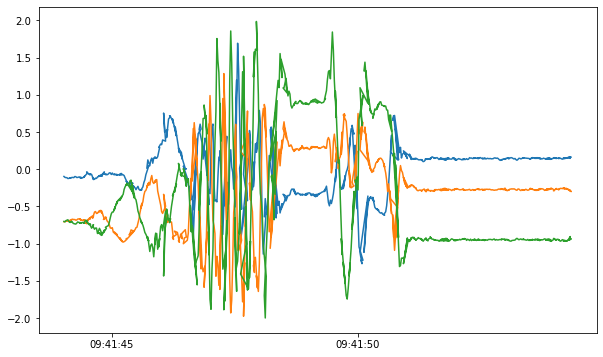

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
for axis in ['x','y','z']:

    ax.plot(pd.to_datetime(data['recorded_timestamp']), data[axis])

In [15]:
connection.cursor().execute('''drop table acc''')

In [16]:
connection.close()